/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/utils.py:542: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)
/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


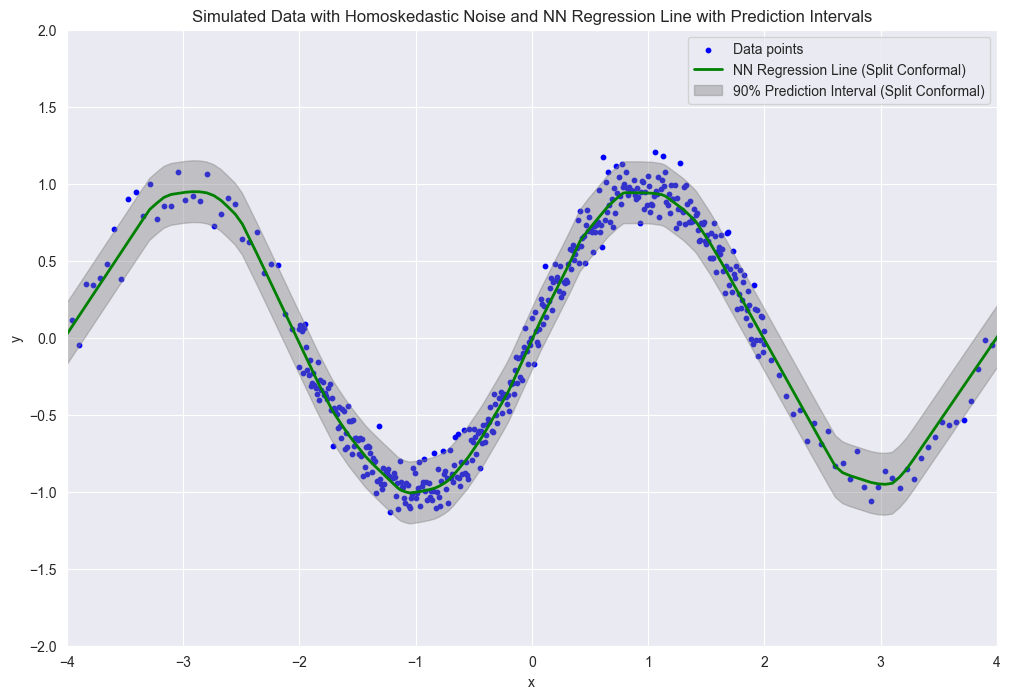

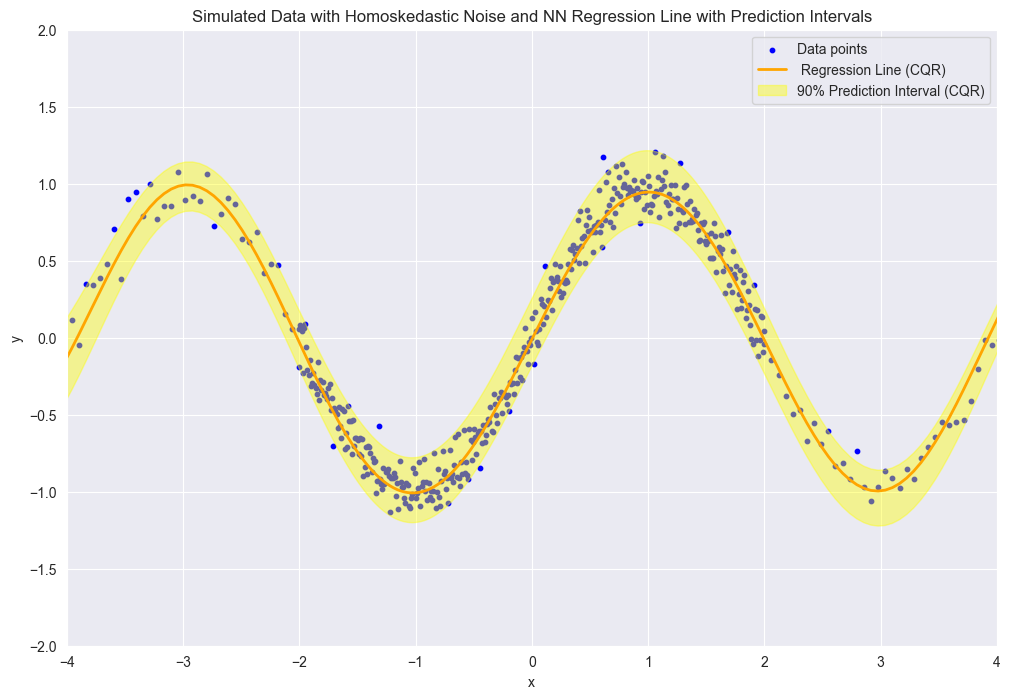

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPRegressor
from mapie.regression import MapieRegressor, MapieQuantileRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import QuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Seed for reproducibility
np.random.seed(30)

# Generating X values with more data points in the center and fewer on the edges
x_center = np.linspace(-2, 2, 400).reshape(-1, 1)
x_left = np.linspace(-5, -2, 50).reshape(-1, 1)
x_right = np.linspace(2, 5, 50).reshape(-1, 1)
x = np.concatenate((x_left, x_center, x_right))

# Generating Y values with homoskedastic noise based on a sine curve
sigma = 0.1
epsilon = np.random.normal(0, sigma, size=x.shape).flatten()
y = np.sin(x * np.pi/2).flatten() + epsilon

# Creating a dataframe
data_homo = pd.DataFrame({'X': x.flatten(), 'Y': y})

# Neural network regressor
nn_regressor = MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', solver='adam', max_iter=2000, random_state=40)

# Split data for conformal prediction
x_train, x_calib, y_train, y_calib = train_test_split(x, y, test_size=0.2, random_state=24)

# Train the neural network on training data
nn_regressor.fit(x_train, y_train)

# MAPIE for split conformal prediction
mapie_split = MapieRegressor(nn_regressor, method="naive", cv="split")
mapie_split.fit(x_train, y_train)
y_pred_split, y_pis_split = mapie_split.predict(x, alpha=0.1)

# MAPIE for conformalized quantile regression
degree_polyn = 10
polyn_model_quant = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=degree_polyn)),
        ("linear", QuantileRegressor(solver="highs", alpha=0))
    ]
)
mapie_cqr = MapieQuantileRegressor(polyn_model_quant, method="quantile", cv="split", alpha=0.1)
mapie_cqr.fit(x_train, y_train, random_state=2)
y_pred_cqr, y_pis_cqr = mapie_cqr.predict(x)

# Plotting the data, regression lines, and prediction intervals
plt.figure(figsize=(12, 8))
plt.scatter(x, y, s=10, c='blue', label='Data points')
plt.ylim(-2, 2)
plt.xlim(-4, 4)
# Split conformal prediction
plt.plot(x, y_pred_split, color='green', linewidth=2, label='NN Regression Line (Split Conformal)')
plt.fill_between(x.flatten(), y_pis_split[:, 0].flatten(), y_pis_split[:, 1].flatten(), color='gray', alpha=0.4,
                 label='90% Prediction Interval (Split Conformal)')


plt.title('Simulated Data with Homoskedastic Noise and NN Regression Line with Prediction Intervals')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the data, regression lines, and prediction intervals
plt.figure(figsize=(12, 8))
plt.scatter(x, y, s=10, c='blue', label='Data points')
plt.ylim(-2, 2)
plt.xlim(-4, 4)
# CQR
plt.plot(x, y_pred_cqr, color='orange', linewidth=2, label=' Regression Line (CQR)')
plt.fill_between(x.flatten(), y_pis_cqr[:, 0, 0].flatten(), y_pis_cqr[:, 1, 0].flatten(), color='yellow', alpha=0.4,
                 label='90% Prediction Interval (CQR)')

plt.title('Simulated Data with Homoskedastic Noise and NN Regression Line with Prediction Intervals')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
from mapie.metrics import regression_coverage_score, regression_mean_width_score

# Coverage and width for split conformal prediction
coverage_split = regression_coverage_score(y, y_pis_split[:, 0], y_pis_split[:, 1])
width_split = regression_mean_width_score(y_pis_split[:, 0], y_pis_split[:, 1])

print(f"Split Conformal Prediction - Coverage: {coverage_split:.2f}, Average Width: {width_split:.2f}")

# Coverage and width for CQR
coverage_cqr = regression_coverage_score(y, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0])
width_cqr = regression_mean_width_score(y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0])

print(f"CQR - Coverage: {coverage_cqr:.2f}, Average Width: {width_cqr:.2f}")


Split Conformal Prediction - Coverage: 0.93, Average Width: 0.40
CQR - Coverage: 0.95, Average Width: 0.42


/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
